In [1]:
#pip install arch
#pip install sklearn

In [2]:
# Importo librerie di interesse
import numpy as np 
import pandas as pd # Dataframe
import matplotlib.pyplot as plt # Grafici
#import plotly.express as px # Grafici
from arch import arch_model
from sklearn.decomposition import PCA # Analisi PCA
from sklearn.preprocessing import StandardScaler # Correlazioni nella PCA

In [3]:
# Presetting utili
np.random.seed(2024) # Imposto seed per numeri random

# Definizione degli intervalli di date
inizio_primo_periodo = "2020-04-27"
fine_primo_periodo = "2021-11-30"
inizio_secondo_periodo = "2021-12-01"
fine_secondo_periodo = "2024-03-01"

In [4]:
# Importo dati
data_prezzi: pd.DataFrame = pd.read_excel(r"prezzi_chiusura_unificati_marzo_2019.xlsx", index_col="Date")
    
data_bond: pd.DataFrame = pd.read_excel(r"rendimenti_bond_gov_marzo_2019.xlsx", index_col="Date") 

data_gruppi: pd.DataFrame = pd.read_excel(r"Classificazione e divisione-31.xlsx") 
    
data_fed_all: pd.DataFrame = pd.read_excel(r"Annunci_FED_marzo_2019.xlsx", sheet_name='PM Selected esteso') # All, PM, PM Selected, PM Selected esteso, Other, Speech
    
data_bce_all: pd.DataFrame = pd.read_excel(r"Annunci_BCE_marzo_2019.xlsx", sheet_name='PM') # All, PM, PM-esteso, PM-1periodo-esteso, Other

#### RENDIMENTI INDICI AZIONARI ####
Procediamo calcolando i rendimenti giornalieri logaritmici degli indici azionari di ogni stato. La pulizia dei dati mancanti verrà effettuata successivamente in ciascun gruppo di paesi.

In [5]:
df: pd.DataFrame = np.log(data_prezzi).diff()  #per il GARCH SI PUO' MOLTIPLICARE *100 IN QUESTA FASE, CAMBIA LA SCALA MA NON I RISULTATI
#print(log_ret_prezzi)
#log_ret_prezzi.to_csv('log_ret_prezzi.csv', header=True)

In [6]:
# Funzione per sostituire con 0 i NaN se sono al massimo due consecutivi
def sostituisci_nan_consecutivi_con_zero(df):
    for colonna in df.columns:
        # Identificazione delle posizioni dei NaN
        serie = df[colonna].isna()
        
        # Gruppi di NaN consecutivi e loro lunghezza
        gruppi_nan = serie.ne(serie.shift()).cumsum()[serie]
        
        # Conteggio della lunghezza di ciascun gruppo di NaN
        conteggi_nan = gruppi_nan.map(gruppi_nan.value_counts())
        
        # Identificazione dei NaN che sono in gruppi di lunghezza 1 o 2
        nan_da_sostituire = conteggi_nan <= 0
        
        # Sostituzione dei NaN selezionati con 0
        df.loc[nan_da_sostituire.index[nan_da_sostituire], colonna] = 0
        
    return df

# Applicazione della funzione al DataFrame
log_ret_prezzi = sostituisci_nan_consecutivi_con_zero(df)

#print(df)


#### GRUPPI DEI PAESI ####
Estraiamo dal file excel 'data_gruppi' i nomi dei Paesi che utilizzeremo per suddividerli in gruppi con i rispettivi rendimenti azionari riportati in 'log_ret_prezzi'.

In [50]:
# Creazione delle liste per ogni gruppo di paesi
colonne_data_gruppi = ['MONDO', 'EMU', 'DV-exEMU', 'EM', 'EM-EMEA', 'EM-A&P', 'EM-AM']
colonne_data_indici = ['DV-idx', 'EM-idx']

liste_paesi = {colonna: data_gruppi[colonna].dropna().tolist() for colonna in colonne_data_gruppi}
liste_indici = {colonna: data_gruppi[colonna].dropna().tolist() for colonna in colonne_data_indici}
# Per accedere a una specifica lista chiamare: liste_paesi['EMEA']

#print(liste_indici['DV-idx'])

['AUSTRALIA', 'AUSTRIA', 'COREA DEL SUD', 'DANIMARCA', 'FINLANDIA', 'FRANCIA', 'GERMANIA', 'GIAPPONE', 'IRLANDA', 'ITALIA', 'NORVEGIA', 'NUOVA ZELANDA', 'PAESI BASSI', 'POLONIA', 'PORTOGALLO', 'SPAGNA', 'UK', 'USA']


#### DIVISIONE DEI PAESI IN GRUPPI ####
Suddivido il dataframe log_ret_prezzi in gruppi seguendo le liste contenenti in colonne_data_gruppi. 

In [8]:
# Creazione di un dizionario per contenere i dataframe filtrati per gruppo
# Contiene un dataframe per ogni gruppo
data_lret_gruppi = {}

# Iterazione su ogni gruppo definito in liste_paesi
for nome_gruppo, lista_paesi in liste_paesi.items():
    # Filtraggio di log_ret_prezzi per selezionare solo le colonne corrispondenti ai paesi del gruppo
       data_log_ret_gruppo = log_ret_prezzi[lista_paesi].dropna() # In questa fase elimino i valori mancanti, mi permette di salvare dati vista la suddivisione in gruppi
       # Salvataggio del dataframe filtrato nel dizionario con la chiave corrispondente al nome del gruppo
       data_lret_gruppi[nome_gruppo] = data_log_ret_gruppo

data_lret_indici = {}

for nome_indice, lista_Paesi in liste_indici.items():
    # Filtraggio di log_ret_prezzi per selezionare solo le colonne corrispondenti ai paesi del gruppo
    data_log_ret_indice = log_ret_prezzi[lista_Paesi] # In questa fase elimino i valori mancanti, mi permette di salvare dati vista la suddivisione in gruppi
    # Salvataggio del dataframe filtrato nel dizionario con la chiave corrispondente al nome del gruppo
    data_lret_indici[nome_indice] = data_log_ret_indice

In [9]:
# A questo punto, data_lret_gruppi contiene un dataframe per ogni gruppo di paesi.
# Per estrarre uno specifico dataset inerente a un gruppo:
# nome_a_scelta = data_lret_gruppi['EMU']

# Per visualizzare l'elenco dei gruppi (le chiavi del dizionario):
#print(list(data_lret_gruppi.keys()))

# Per visualizzare il dataframe di un gruppo specifico:
#print(data_lret_gruppi['ASIA & PACIFICO'])

#print(data_lret_indici['DV-idx'])
#print(list(data_lret_indici.keys()))


#### DIVISIONE DEI GRUPPI IN PERIODI ####
Divido ogni gruppo in 2 sottocampioni temporali, che rimarcano il cambio di politica monetaria

In [10]:
# Creazione di un nuovo dizionario per contenere i dataframe divisi per periodo
data_lret_gruppi_periodi = {}

for nome_gruppo, df in data_lret_gruppi.items():
    # Divisione del dataframe in base agli intervalli di date
    primo_periodo_df = df.loc[inizio_primo_periodo:fine_primo_periodo]
    secondo_periodo_df = df.loc[inizio_secondo_periodo:fine_secondo_periodo]
    
    # Salvataggio dei dataframe divisi nel nuovo dizionario
    # La chiave è una tupla contenente il nome del gruppo e la descrizione del periodo
    data_lret_gruppi_periodi[(nome_gruppo, 'Primo Periodo')] = primo_periodo_df
    data_lret_gruppi_periodi[(nome_gruppo, 'Secondo Periodo')] = secondo_periodo_df

data_lret_indici_periodi = {}

for nome_indice, df in data_lret_indici.items():
    # Divisione del dataframe in base agli intervalli di date
    primo_periodo_df = df.loc[inizio_primo_periodo:fine_primo_periodo]
    secondo_periodo_df = df.loc[inizio_secondo_periodo:fine_secondo_periodo]
    
    # Salvataggio dei dataframe divisi nel nuovo dizionario
    # La chiave è una tupla contenente il nome del gruppo e la descrizione del periodo
    data_lret_indici_periodi[(nome_indice, 'Primo Periodo')] = primo_periodo_df
    data_lret_indici_periodi[(nome_indice, 'Secondo Periodo')] = secondo_periodo_df


In [11]:
# A questo punto, data_lret_gruppi_periodi contiene i dataframe per ogni gruppo, divisi per periodo.

# Per accedere ai dataframe di un gruppo e periodo specifici:
# nome_a_scelta_primo_periodo = data_lret_gruppi_periodi[('EMU', 'Primo Periodo')]
# nome_a_scelta_seconso_periodo = data_lret_gruppi_periodi[('EMU', 'Secondo Periodo')]

# Per vedere l'elenco dei gruppi e periodi (le chiavi del dizionario), puoi fare così:
# print(list(data_lret_gruppi_periodi.keys()))

# E per visualizzare il dataframe di un gruppo e periodo specifico, ad esempio 'EMU' nel 'Primo Periodo':
#print(data_lret_gruppi_periodi[('EMU', 'Primo Periodo')])
#print(data_lret_indici_periodi[('EM-idx', 'Secondo Periodo')])

#### RETURN INDEX SVILUPPATI ED EMERGENTI ####
In questa fase creiamo 2 indici che rispecchiano l'andamento dei rendimenti dei paesi sviluppati ed emergenti. Gli indici sono costruiti svolgendo una media semplice dei log-rendimenti dei paesi che compongono la rispettiva categoria

In [12]:
# Assicurati che 'DV_idx' sia il nome corretto usato nel tuo dizionario. Se necessario, sostituiscilo con il nome esatto.

# Estrazione dei dataframe per i due periodi dal dizionario
DV_idx_primo_periodo_df = data_lret_indici_periodi[('DV-idx', 'Primo Periodo')]
DV_idx_secondo_periodo_df = data_lret_indici_periodi[('DV-idx', 'Secondo Periodo')]

# Calcolo della media equamente pesata per ogni data
DV_index_primo_periodo = DV_idx_primo_periodo_df.mean(axis=1)
DV_index_secondo_periodo = DV_idx_secondo_periodo_df.mean(axis=1)

# Ora DV_index_primo_periodo e DV_index_secondo_periodo contengono gli indici calcolati come media dei rendimenti logaritmici per ogni data.
#print(DV_index_primo_periodo)
#print(DV_index_secondo_periodo)

In [13]:
# Assicurati che 'EM_idx' sia il nome corretto usato nel tuo dizionario. Se necessario, sostituiscilo con il nome esatto.

# Estrazione dei dataframe per i due periodi dal dizionario per EM_idx
EM_idx_primo_periodo_df = data_lret_indici_periodi[('EM-idx', 'Primo Periodo')]
EM_idx_secondo_periodo_df = data_lret_indici_periodi[('EM-idx', 'Secondo Periodo')]

# Calcolo della media equamente pesata per ogni data per EM_idx
EM_index_primo_periodo = EM_idx_primo_periodo_df.mean(axis=1)
EM_index_secondo_periodo = EM_idx_secondo_periodo_df.mean(axis=1)

# Ora EM_index_primo_periodo e EM_index_secondo_periodo contengono gli indici calcolati come media dei rendimenti logaritmici per ogni data per EM_idx.
#print(EM_index_primo_periodo)
#print(EM_index_secondo_periodo)

In [14]:
# Creazione del dataframe per il primo periodo
index_primo_periodo = pd.DataFrame({
    'DV_index_primo_periodo': DV_index_primo_periodo,
    'EM_index_primo_periodo': EM_index_primo_periodo
})

# Creazione del dataframe per il secondo periodo
index_secondo_periodo = pd.DataFrame({
    'DV_index_secondo_periodo': DV_index_secondo_periodo,
    'EM_index_secondo_periodo': EM_index_secondo_periodo
})

# Impostazione dell'indice temporale sui nuovi dataframe
index_primo_periodo.index = DV_index_primo_periodo.index
index_secondo_periodo.index = DV_index_secondo_periodo.index

index_primo_periodo = index_primo_periodo.dropna()
index_secondo_periodo = index_secondo_periodo.dropna()

#print(index_primo_periodo)
#print(index_secondo_periodo)

In [15]:
# Aggiunta di index_primo_periodo al dizionario data_lret_gruppi_periodi
data_lret_gruppi_periodi[('Index', 'Primo Periodo')] = index_primo_periodo

# Aggiunta di index_secondo_periodo al dizionario data_lret_gruppi_periodi
data_lret_gruppi_periodi[('Index', 'Secondo Periodo')] = index_secondo_periodo

# Verifica del dizionario per vedere le nuove chiavi aggiunte
#print(list(data_lret_gruppi_periodi.keys()))


In [51]:
#data_lret_gruppi_periodi[('Index', 'Primo Periodo')]

,DV_index_primo_periodo,EM_index_primo_periodo
Date,,
2020-04-27,0.014000,0.008162
2020-04-28,0.013122,0.011856
2020-04-29,0.021785,0.012285
2020-04-30,-0.009600,-0.001906
2020-05-05,0.012394,0.007494
...,...,...
2021-11-24,-0.000016,0.003553
2021-11-25,0.003299,0.000642
2021-11-26,-0.032902,-0.015092


#### GARCH #####

In [17]:
# OPZIONE 1 SCALA IN %
#def applica_garch(serie_rendimenti):
    # Definizione del modello GJR-GARCH(1,1,1)
#    model = arch_model(serie_rendimenti, vol='Garch', p=1, o=1, q=1, dist='Normal')
    # Stima del modello
#    results = model.fit(disp='off')  # 'off' per non stampare l'output dell'ottimizzazione
    # Calcolo dei residui standardizzati
#    residui_std =  results.resid / results.conditional_volatility
#    return residui_std

In [18]:
# OPZIONE 2 SCALA NON %
def applica_garch(serie_rendimenti):
    # Riscalamento dei rendimenti
    serie_rendimenti_riscalati = serie_rendimenti * 100
    
    # Inizializzazione del modello GARCH(1,1,1) con distribuzione normale dei residui
    model = arch_model(serie_rendimenti_riscalati, vol='Garch', p=1, o=1, q=1, dist='Normal')
    
    # Stima dei parametri del modello senza mostrare output intermedio (disp='off')
    results = model.fit(disp='off')
    
    # Calcolo dei residui standardizzati e riscala indietro
    residui_std = (results.resid / results.conditional_volatility) / 100
    
    return residui_std


In [19]:
residui_std_dizionario = {}

for chiave, df in data_lret_gruppi_periodi.items():
    # Assicurati che df non contenga valori NaN
    df_clean = df.dropna(axis=0, how='any')
    
    residui_std_df = df_clean.apply(lambda colonna: applica_garch(colonna), result_type='expand')
    
    # Salva il dataframe dei residui standardizzati nel nuovo dizionario
    residui_std_dizionario[chiave] = residui_std_df

In [20]:
#residui_std_dizionario

#### YIELD CURVE GERMANIA E STATI UNITI
In questa fasa iniza l'analisi delle variazioni delle yield curve obbligazionarie della Germania e degli Stati Uniti, ciascuna delle quali verrà utilizzata come riferimento per determinare se l'impatto degli annunci di politica monetaria della BCE e della FED sono stati effettivamente rilevanti. 
Per far ciò la prima cosa da fare e calcolare la prima differenza dei rendimenti obbligazionari per ciascuna scadenza e per ciascuno stato.

In [21]:
# Calcolo le variazioni giornaliere dei rendimenti obbligazionari
bond_ret: pd.DataFrame = data_bond.diff().dropna()
#print(bond_ret)

Ora si procede con l'analisi della componente principale (PCA). Questa è una tecnica statistica utilizzata per ridurre la dimensionalità dei dati mantenendo la maggior parte delle informazioni originali. Questo viene fatto identificando le "componenti principali" lungo le quali i dati variano maggiormente. Nel contesto dei rendimenti dei titoli di stato, la PCA può essere applicata alle variazioni giornaliere dei rendimenti per identificare il fattore principale che spiega la maggior parte della variazione complessiva nella yield curve.
Nel codice utilizziamo la libreria sklearn.decomposition che svolge in automatico l'analisi.
Per "addestramento" si intende il processo di adattamento del modello ai dati per identificare le componenti principali.

Nella PCA, l'addestramento consiste nei seguenti passaggi:

##### 1. Calcolo della Matrice di Covarianza: 
La PCA inizia calcolando la matrice di covarianza dei dati. Questa matrice aiuta a comprendere come le diverse variabili (ad esempio, i rendimenti dei titoli di stato a diverse scadenze) variano congiuntamente.
##### 2. Calcolo degli Autovalori e degli Autovettori:
Gli autovalori e gli autovettori della matrice di covarianza vengono calcolati. Gli autovettori rappresentano le direzioni (o componenti principali) lungo le quali i dati presentano la maggiore varianza, mentre gli autovalori indicano l'importanza (o la quantità di varianza) di ciascuna direzione.
##### 3. Selezione delle Componenti Principali:
Le componenti (autovettori) vengono selezionate in base alla loro importanza, determinata dagli autovalori corrispondenti. In genere, si scelgono le componenti che catturano la maggior parte della varianza nei dati.
##### 4. Trasformazione dei Dati:
Infine, i dati originali vengono proiettati (trasformati) sulle componenti principali selezionate. Questo passaggio riduce la dimensionalità dei dati mantenendo la maggior parte delle informazioni originali.

L'addestramento serve a rendere il modello PCA in grado di identificare le caratteristiche più significative dei dati, facilitando l'analisi riducendo il rumore e la complessità. Nel contesto dell'analisi dei rendimenti dei titoli di stato, questo significa isolare i movimenti principali della yield curve.

In [22]:
# Filtro i dati per Germania (GER) e USA
bond_ret_ger_tot = bond_ret.filter(like='GER')
bond_ret_usa_tot = bond_ret.filter(like='USA')

bond_ret_ger = bond_ret_ger_tot.loc[inizio_primo_periodo:fine_secondo_periodo]
bond_ret_usa = bond_ret_usa_tot.loc[inizio_primo_periodo:fine_secondo_periodo]


def apply_pca_and_classify(bond_ret_country):
    
    scaler = StandardScaler()
    
    df = scaler.fit_transform(bond_ret_country)

    
    pca = PCA(n_components=1) # Numero di componenti che vogliamo tenere. In questo caso il valore è settato a 1 perchè vogliamo la prima componente principale
                              # PCA è la funzione importata da sklearn.decomposition che crea un oggetto PCA che svolge la decomposizione i una unica componente
    principal_components = pca.fit_transform(df) # Adatta il modello addestrandolo con i dati forniti, ossia bond_ret_country e riduce la dimensionalità sugli stessi dati utilizzati per l'addestramento
                                                               # Il risultato è un array che contiene i valori dei dati proiettati sulla componente principale, evidenziando la variazione principale dei rendimenti per quel periodo.
    principal_component_series = pd.Series(principal_components.flatten(), index=bond_ret_country.index) # Trasformiamo tutto in una serie pandas unidimensionale, che utilizziamo per i prossimi calcoli
    
    return principal_component_series

# Applico la PCA e classifico per la Germania e gli USA
classified_ger = apply_pca_and_classify(bond_ret_ger)
classified_usa = apply_pca_and_classify(bond_ret_usa)

#print(classified_ger)
#print(classified_usa)

#### DATE DEGLI ANNUNCI DI POLITICA MONETARIA ####
In questa fase creiamo i data frame che contengono le date degli annunci distintamente della BCE e della FED che coincidono con movimenti considerevoli della yield curve della germania per la BCE e degli USA per la FED.

Per far questo utilizziamo per ogni banca centrale due elementi, ossia le date degli annunci di politica monetaria (date_bce_all e date_fed_fed) e la classificazione dei movimenti delle yield curve (classified_dates_ger_low/high e classified_usa_low/high). Con la funzione .isin() filtro le date degli annunci di politica monetaria verificando se ricadono in una data high o low e le inserisco in un dataframe sotto la colonna 'Date' che imposto come indice. 

Successivamente aggiungo ai dataframe (chiamati date_bce_high/low e date_fed_high/low ) una colonna chiamata 'Classification' che associa a ogni annunci di PM l'evento high o low.

In [23]:
# Estrazione di tutte le date degli annunci di politica monetaria ----ALL----
date_fed = pd.to_datetime(data_fed_all.iloc[:, 0]).dropna() # Per considerare altre date modificare 'data_fed_pm'
date_bce = pd.to_datetime(data_bce_all.iloc[:, 0]).dropna() # Per considerare altre date modificare 'data_bce_pm'

# Suddivisione delle date di annuncio della FED nei due periodi definiti
date_fed_primo_periodo = date_fed[(date_fed >= inizio_primo_periodo) & (date_fed <= fine_primo_periodo)]
date_fed_secondo_periodo = date_fed[(date_fed >= inizio_secondo_periodo) & (date_fed <= fine_secondo_periodo)]

# Suddivisione delle date di annuncio della BCE nei due periodi definiti
date_bce_primo_periodo = date_bce[(date_bce >= inizio_primo_periodo) & (date_bce <= fine_primo_periodo)]
date_bce_secondo_periodo = date_bce[(date_bce >= inizio_secondo_periodo) & (date_bce <= fine_secondo_periodo)]

# Verifica delle suddivisioni
#print(date_fed_primo_periodo)
#print(date_fed_secondo_periodo)
#print(date_bce_primo_periodo)
#print(date_bce_secondo_periodo)


In [24]:
def classify_values_adjusted(date_bc_periodo, b_pca_bench):
    # Filtrazione dei valori in b_pca_bench per le date presenti in date_bc_periodo
    filtered_values = b_pca_bench[b_pca_bench.index.isin(date_bc_periodo)]
    
    # Creazione del DataFrame con date e valori filtrati
    df = pd.DataFrame({
        'date': filtered_values.index,
        'values': filtered_values.values
    })
    
    # Calcolo del primo e secondo terzile dei valori filtrati
    first_tertile = np.percentile(filtered_values.values, 33.33)
    second_tertile = np.percentile(filtered_values.values, 66.66)
    
    # Sostituzione dei valori basata sui terzili
    df['classification'] = pd.cut(df['values'],
                                  bins=[-np.inf, first_tertile, second_tertile, np.inf],
                                  labels=['low', '', 'high'])
    
    # Eliminazione della colonna 'values' per visualizzare solo la classificazione
    df.drop(columns=['values'], inplace=True)
    
    return df


In [25]:
def extract_low_high_values_adjusted(date_bc_periodo, b_pca_bench):
    # Utilizzo della funzione precedente per classificare i valori
    classified_df = classify_values_adjusted(date_bc_periodo, b_pca_bench)
    
    # Estrazione dei valori classificati come 'low'
    date_bc_low = classified_df[classified_df['classification'] == 'low'].copy()
    date_bc_low['Classification'] = 'low'  # Aggiunta della colonna 'Classification' con valore 'low'
    date_bc_low.set_index('date', inplace=True)  # Imposta le date come indice
    
    # Estrazione dei valori classificati come 'high'
    date_bc_high = classified_df[classified_df['classification'] == 'high'].copy()
    date_bc_high['Classification'] = 'high'  # Aggiunta della colonna 'Classification' con valore 'high'
    date_bc_high.set_index('date', inplace=True)  # Imposta le date come indice
    
    # Restituisco i DataFrame contenenti solo le date con classificazione 'low' e 'high' rispettivamente
    return date_bc_low[['Classification']], date_bc_high[['Classification']]

# La chiamata alla funzione è commentata per le ragioni già spiegate.
# Questa versione modificata restituirà due DataFrame distinti: uno per le date classificate come 'low' e uno per quelle classificate come 'high', entrambi con una colonna 'Classification' che indica questa classificazione.


In [52]:
# Suddivisione delle date di annuncio "low" della FED in base ai periodi definiti
date_fed_low_primo_periodo, date_fed_high_primo_periodo = extract_low_high_values_adjusted(date_fed_primo_periodo, classified_usa)
date_fed_low_secondo_periodo, date_fed_high_secondo_periodo = extract_low_high_values_adjusted(date_fed_secondo_periodo, classified_usa)

# Suddivisione delle date di annuncio "low" della BCE in base ai periodi definiti
date_bce_low_primo_periodo, date_bce_high_primo_periodo = extract_low_high_values_adjusted(date_bce_primo_periodo, classified_ger)
date_bce_low_secondo_periodo, date_bce_high_secondo_periodo = extract_low_high_values_adjusted(date_bce_secondo_periodo, classified_ger)


# Verifica delle suddivisioni
#print(date_fed_low_primo_periodo)
#print(date_fed_high_primo_periodo)
#print(date_fed_low_secondo_periodo)
#print(date_fed_high_secondo_periodo)
#print(date_bce_low_primo_periodo)
#print(date_bce_high_primo_periodo)
#print(date_bce_low_secondo_periodo)
#print(date_bce_high_secondo_periodo)


#### CREIAMO LE FINESTRE DI ANNUNCIO ####

In [27]:
def crea_calendario_espanso_completo(date_annunci):
    calendario_espanso = set()

    for data in date_annunci:
        data = pd.to_datetime(data)
        giorno_settimana = data.weekday()

        # Imposta i giorni da aggiungere per il caso generale
        date_da_aggiungere = [-2, -1, 0, 1, 2]
        
        # Aggiusta i giorni da aggiungere per casi specifici
        if giorno_settimana == 0:  # Lunedì
            date_da_aggiungere = [-4, -3, 0, 1, 2]  # Aggiunge il giovedì e venerdì precedente
        elif giorno_settimana == 1:  # Martedì
            date_da_aggiungere = [-4, -3, -1, 0, 1]  # Aggiunge il giovedì e venerdì precedente
        elif giorno_settimana == 3:  # Giovedì
            date_da_aggiungere = [-2, -1, 0, 1, 4]  # Aggiunge il lunedì successivo
        elif giorno_settimana == 4:  # Venerdì
            date_da_aggiungere = [-2, -1, 0, 3, 4]  # Aggiunge il lunedì e martedì successivi

        # Genera e aggiunge le date al calendario, escludendo weekend
        for offset in date_da_aggiungere:
            data_offset = data + pd.DateOffset(days=offset)
            if data_offset.weekday() < 5:  # Escludi sabato e domenica
                calendario_espanso.add(data_offset)

    # Ordina il set per convertirlo in una lista ordinata di date
    calendario_espanso_ordinato = sorted(list(calendario_espanso))
    
    return calendario_espanso_ordinato



In [28]:
#RESTA UGUALE____________________________________________________________________________________________
# ALL
bce_all_espanso_pp = crea_calendario_espanso_completo(date_bce_primo_periodo)
bce_all_espanso_sp = crea_calendario_espanso_completo(date_bce_secondo_periodo)
fed_all_espanso_pp = crea_calendario_espanso_completo(date_fed_primo_periodo)
fed_all_espanso_sp = crea_calendario_espanso_completo(date_fed_secondo_periodo)

# BCE - high
bce_high_espanso_pp = crea_calendario_espanso_completo(date_bce_high_primo_periodo.index)
bce_high_espanso_sp = crea_calendario_espanso_completo(date_bce_high_secondo_periodo.index)

# BCE - low
bce_low_espanso_pp = crea_calendario_espanso_completo(date_bce_low_primo_periodo.index)
bce_low_espanso_sp = crea_calendario_espanso_completo(date_bce_low_secondo_periodo.index)

# FED - high
fed_high_espanso_pp = crea_calendario_espanso_completo(date_fed_high_primo_periodo.index)
fed_high_espanso_sp = crea_calendario_espanso_completo(date_fed_high_secondo_periodo.index)

# FED - low
fed_low_espanso_pp = crea_calendario_espanso_completo(date_fed_low_primo_periodo.index)
fed_low_espanso_sp = crea_calendario_espanso_completo(date_fed_low_secondo_periodo.index)


print(len(bce_all_espanso_pp))
print(len(bce_all_espanso_sp))
print(len(fed_all_espanso_pp))
print(len(fed_all_espanso_sp))

print(len(bce_low_espanso_pp))
print(len(bce_high_espanso_pp))
print(len(bce_low_espanso_sp))
print(len(bce_high_espanso_sp))
print(len(fed_low_espanso_pp))
print(len(fed_high_espanso_pp))
print(len(fed_low_espanso_sp))
print(len(fed_high_espanso_sp))


65
90
198
194
20
25
30
30
81
86
71
65


In [29]:
# Supponendo che 'dizionario_calendari' sia già stato definito come hai descritto
dizionario_calendari = {
    ('BCE', 'pp', 'low'): bce_low_espanso_pp,
    ('BCE', 'pp', 'high'): bce_high_espanso_pp,
    ('BCE', 'sp', 'low'): bce_low_espanso_sp,
    ('BCE', 'sp', 'high'): bce_high_espanso_sp,
    
    ('FED', 'pp', 'low'): fed_low_espanso_pp,
    ('FED', 'pp', 'high'): fed_high_espanso_pp,
    ('FED', 'sp', 'low'): fed_low_espanso_sp,
    ('FED', 'sp', 'high'): fed_high_espanso_sp,
    
    ('BCE', 'pp', 'all'): bce_all_espanso_pp,
    ('BCE', 'sp', 'all'): bce_all_espanso_sp,
    ('FED', 'pp', 'all'): fed_all_espanso_pp,
    ('FED', 'sp', 'all'): fed_all_espanso_sp,
}



In [30]:
# Inizializza il nuovo dizionario per salvare i risultati
risultati_filtrati = {}

# Definizione preliminare dei periodi per semplificare il riferimento
periodi = {'Primo Periodo': 'pp', 'Secondo Periodo': 'sp'}

# Itera sui gruppi e sui loro dataframe associati
for (nome_gruppo, periodo), df_gruppo in residui_std_dizionario.items():
    # Usa il mapping dei periodi per ottenere 'pp' o 'sp'
    periodo_codice = periodi[periodo]

    # Itera sulle banche centrali
    for bc in ['BCE', 'FED']:
        # Itera sulle discriminanti
        for discriminante in ['low', 'high', 'all', 'no']:
            # Costruisce la chiave per accedere a 'dizionario_calendari'
            chiave_calendario = (bc, periodo_codice, discriminante)
            
            if discriminante == 'no':
                # Calcola le date "no" sottraendo 'all' dalle date del gruppo
                calendario_all = set(dizionario_calendari[(bc, periodo_codice, 'all')])
                date_no = set(df_gruppo.index) - calendario_all
                # Filtra il dataframe del gruppo per le date in 'no'
                df_filtrato = df_gruppo.loc[df_gruppo.index.isin(date_no)]
            else:
                # Usa il calendario espanso per filtrare direttamente le date
                calendario = set(dizionario_calendari[chiave_calendario])
                df_filtrato = df_gruppo.loc[df_gruppo.index.isin(calendario)]
            
            # Qui potresti applicare la PCA o altre analisi su 'df_filtrato'
            # (Codice per l'analisi non mostrato)

            # Salva 'df_filtrato' nel dizionario dei risultati
            risultati_filtrati[(bc, nome_gruppo, periodo, discriminante)] = df_filtrato

# A questo punto, `risultati_filtrati` contiene tutti i dataframe filtrati
# con chiavi che riflettono la banca centrale, il nome del gruppo, il periodo e la discriminante
#print(risultati_filtrati.keys())
#print(risultati_filtrati['BCE','EMU','Primo Periodo', 'low'])

In [31]:
#SERVE COME CONTROLLO
def stampa_valori_ordinati_lunghezze(dizionario):
    ordine_bc = ['BCE', 'FED']
    ordine_stati = ['MONDO', 'EMU', 'DV-exEMU', 'EM', 'EM-EMEA', 'EM-A&P', 'EM-AM', 'Index']
    ordine_periodi = ['Primo Periodo', 'Secondo Periodo']
    ordine_discriminante = ['low', 'high', 'all', 'no']
    i = 0 
    for bc in ordine_bc:
        for stato_index, stato in enumerate(ordine_stati):
            # Aggiunta di una rientranza di 1 tab all'inizio di ogni nuovo stato
            print("\t", end='')  # Rientranza per nuovo stato
            
            if stato == 'ASIA & PACIFICO':
                print('A\\&P', end=' ')
            elif stato == 'EM-A&P':
                print('EM-A\\&P', end=' ')
            else:
                print(stato, end=' ')
            y = 1
            for periodo_index, periodo in enumerate(ordine_periodi):
                for discriminante in ordine_discriminante:
                    i = i + 1
                    key = (bc, stato, periodo, discriminante)
                    if key in dizionario:
                        print(f"&  {len(dizionario[key])}", end=' ')
                    if i == 4 and y != 2: 
                        print('& ', end='')  # Aggiunge '& ' al termine di ciascun periodo, eccetto l'ultimo
                    else:
                        print('', end='')
                i = 0
                y = y + 1
            print('\\\\')  # Va a capo solo al cambio di stato
        print('')
#print(len(risultati_filtrati['BCE', 'MONDO', 'Secondo Periodo', 'high']))
#print(risultati_filtrati['FED', 'Index', 'Primo Periodo', 'all'])
#print(data_lret_gruppi_periodi['Index','Secondo Periodo'])

stampa_valori_ordinati_lunghezze(risultati_filtrati)

	MONDO &  7 &  8 &  19 &  114 & &  17 &  7 &  43 &  145 \\
	EMU &  17 &  23 &  59 &  328 & &  29 &  25 &  82 &  458 \\
	DV-exEMU &  13 &  16 &  45 &  245 & &  26 &  20 &  69 &  336 \\
	EM &  11 &  11 &  27 &  145 & &  17 &  11 &  48 &  200 \\
	EM-EMEA &  14 &  15 &  44 &  281 & &  27 &  24 &  79 &  385 \\
	EM-A\&P &  16 &  18 &  45 &  224 & &  22 &  17 &  64 &  344 \\
	EM-AM &  17 &  15 &  45 &  263 & &  25 &  23 &  68 &  366 \\
	Index &  20 &  23 &  63 &  351 & &  30 &  29 &  89 &  498 \\

	MONDO &  25 &  24 &  49 &  84 & &  20 &  15 &  59 &  129 \\
	EMU &  75 &  83 &  182 &  205 & &  67 &  64 &  183 &  357 \\
	DV-exEMU &  50 &  51 &  119 &  171 & &  52 &  45 &  133 &  272 \\
	EM &  33 &  34 &  71 &  101 & &  26 &  20 &  74 &  174 \\
	EM-EMEA &  60 &  65 &  148 &  177 & &  57 &  47 &  155 &  309 \\
	EM-A\&P &  59 &  53 &  127 &  142 & &  52 &  45 &  138 &  270 \\
	EM-AM &  59 &  63 &  137 &  171 & &  48 &  48 &  134 &  300 \\
	Index &  79 &  83 &  192 &  222 & &  71 &  65 &  192 &  39

In [32]:
# Dizionario per salvare la varianza spiegata per ogni componente
varianza_spiegata_dizionario = {}

# Itera su ogni chiave e dataframe in risultati_filtrati
for chiave, df_s in risultati_filtrati.items():
    # Assicurati che il DataFrame non sia vuoto
    if not df_s.empty:
        scaler = StandardScaler()
        df = scaler.fit_transform(df_s)
        # Inizializza l'oggetto PCA per calcolare la prima componente principale
        pca = PCA(n_components=1)
        
        # Adatta il modello ai dati: non è necessario calcolare esplicitamente la matrice di correlazione
        pca.fit(df)
        
        # La varianza spiegata dalla prima componente principale viene ottenuta direttamente
        varianza_spiegata_primo_autovalore = pca.explained_variance_ratio_[0] * 100  # Già in percentuale
        
        # Arrotondamento della varianza spiegata al secondo decimale
        varianza_spiegata_primo_autovalore_arrotondato = round(varianza_spiegata_primo_autovalore, 2)
        
        # Salvataggio della varianza spiegata nel dizionario
        varianza_spiegata_dizionario[chiave] = varianza_spiegata_primo_autovalore_arrotondato

# Stampa o verifica dei risultati
for chiave, varianza in varianza_spiegata_dizionario.items():
    print(f"{chiave}: {varianza}")

('BCE', 'MONDO', 'Primo Periodo', 'low'): 51.4
('BCE', 'MONDO', 'Primo Periodo', 'high'): 31.32
('BCE', 'MONDO', 'Primo Periodo', 'all'): 35.82
('BCE', 'MONDO', 'Primo Periodo', 'no'): 37.94
('FED', 'MONDO', 'Primo Periodo', 'low'): 43.4
('FED', 'MONDO', 'Primo Periodo', 'high'): 43.46
('FED', 'MONDO', 'Primo Periodo', 'all'): 43.11
('FED', 'MONDO', 'Primo Periodo', 'no'): 33.16
('BCE', 'MONDO', 'Secondo Periodo', 'low'): 46.31
('BCE', 'MONDO', 'Secondo Periodo', 'high'): 37.25
('BCE', 'MONDO', 'Secondo Periodo', 'all'): 38.57
('BCE', 'MONDO', 'Secondo Periodo', 'no'): 36.08
('FED', 'MONDO', 'Secondo Periodo', 'low'): 41.41
('FED', 'MONDO', 'Secondo Periodo', 'high'): 31.78
('FED', 'MONDO', 'Secondo Periodo', 'all'): 37.06
('FED', 'MONDO', 'Secondo Periodo', 'no'): 36.09
('BCE', 'EMU', 'Primo Periodo', 'low'): 76.31
('BCE', 'EMU', 'Primo Periodo', 'high'): 75.27
('BCE', 'EMU', 'Primo Periodo', 'all'): 77.85
('BCE', 'EMU', 'Primo Periodo', 'no'): 77.24
('FED', 'EMU', 'Primo Periodo', 'l

In [33]:
def stampa_valori_ordinati(dizionario):
    ordine_bc = ['BCE', 'FED']
    ordine_stati = ['MONDO', 'EMU', 'DV-exEMU', 'EM', 'EM-EMEA', 'EM-A&P', 'EM-AM', 'Index']
    ordine_periodi = ['Primo Periodo', 'Secondo Periodo']
    ordine_discriminante = ['low', 'high', 'all', 'no']
    i = 0 
    for bc in ordine_bc:
        for stato_index, stato in enumerate(ordine_stati):
            # Aggiunta di una rientranza di 1 tab all'inizio di ogni nuovo stato
            print("\t", end='')  # Rientranza per nuovo stato
            
            if stato == 'ASIA & PACIFICO':
                print('A\\&P', end=' ')
            elif stato == 'EM-A&P':
                print('EM-A\\&P', end=' ')
            else:
                print(stato, end=' ')
            y = 1
            for periodo_index, periodo in enumerate(ordine_periodi):
                for discriminante in ordine_discriminante:
                    i = i + 1
                    key = (bc, stato, periodo, discriminante)
                    if key in dizionario:
                        print(f"& {round(dizionario[key],2)}", end=' ')
                    if i == 4 and y != 2: 
                        print('& ', end='')  # Aggiunge '& ' al termine di ciascun periodo, eccetto l'ultimo
                    else:
                        print('', end='')
                i = 0
                y = y + 1
            print('\\\\')  # Va a capo solo al cambio di stato
        print('')

In [34]:
stampa_valori_ordinati(varianza_spiegata_dizionario)

	MONDO & 51.4 & 31.32 & 35.82 & 37.94 & & 46.31 & 37.25 & 38.57 & 36.08 \\
	EMU & 76.31 & 75.27 & 77.85 & 77.24 & & 88.53 & 61.89 & 76.07 & 75.56 \\
	DV-exEMU & 37.22 & 45.1 & 39.14 & 38.14 & & 41.76 & 35.6 & 39.09 & 40.97 \\
	EM & 37.91 & 28.53 & 25.79 & 25.32 & & 27.6 & 32.78 & 22.33 & 24.41 \\
	EM-EMEA & 48.52 & 40.96 & 38.04 & 43.64 & & 49.23 & 41.98 & 35.62 & 39.37 \\
	EM-A\&P & 38.9 & 45.18 & 35.54 & 41.28 & & 61.12 & 41.99 & 42.5 & 39.22 \\
	EM-AM & 57.81 & 37.31 & 46.92 & 36.2 & & 50.0 & 35.6 & 44.95 & 39.77 \\
	Index & 81.91 & 71.75 & 80.05 & 84.83 & & 77.36 & 77.16 & 78.89 & 79.06 \\

	MONDO & 43.4 & 43.46 & 43.11 & 33.16 & & 41.41 & 31.78 & 37.06 & 36.09 \\
	EMU & 82.76 & 80.9 & 80.67 & 72.94 & & 78.4 & 72.12 & 76.38 & 75.13 \\
	DV-exEMU & 42.06 & 31.65 & 38.5 & 38.06 & & 41.39 & 33.13 & 40.84 & 40.67 \\
	EM & 35.87 & 34.93 & 32.75 & 17.81 & & 36.81 & 33.25 & 27.47 & 21.75 \\
	EM-EMEA & 49.65 & 46.21 & 48.36 & 35.81 & & 45.33 & 39.13 & 38.14 & 38.99 \\
	EM-A\&P & 51.99 & 45.

In [35]:
# Assumi che 'risultati_filtrati' sia il dizionario corretto contenente i DataFrame per le chiavi specificate
#num_iterazioni = 200
#giorni_per_finestra = 5  # Numero di giorni per finestra

#varianza_spiegata_distribuzione = {}

#for chiave, df_gruppo in risultati_filtrati.items():
#    bc, paese, periodo_codice, discriminante = chiave
#    if discriminante == 'no':
#        for dis_2 in ['low', 'high', 'all']:  # Correzione: aggiunta del colon dopo 'for dis_2 in ['low','high','all']'
#            varianze_spiegate_iterazione = []
            # Calcola il numero minimo di finestre tra 'no' e l'altra discriminante
#            num_finestre = min(int(len(df_gruppo) / giorni_per_finestra), int(len(risultati_filtrati[(bc, paese, periodo_codice, dis_2)]) / giorni_per_finestra))

#            for _ in range(num_iterazioni):
#                dati_finestre = []  # Lista per raccogliere i DataFrame delle finestre

#                if num_finestre > 0:  # Controlla se il numero di finestre è maggiore di zero
#                    for _ in range(num_finestre):
                        # Estrai casualmente 'giorni_per_finestra' date senza preoccuparti della consecutività
#                        campione_date = df_gruppo.sample(n=giorni_per_finestra)
#                        dati_finestre.append(campione_date)

                    # Concatena tutti i DataFrame selezionati in un unico DataFrame
#                    dati_finestre_concatenati = pd.concat(dati_finestre, axis=0)

#                    if not dati_finestre_concatenati.empty:
                        # Standardizzazione dei dati
#                        scaler = StandardScaler()
#                        matrice_finestre = scaler.fit_transform(dati_finestre_concatenati)

                        # Applicazione della PCA
#                        pca = PCA(n_components=1)
#                        pca.fit(matrice_finestre)
#                        varianza = pca.explained_variance_ratio_[0] * 100  # Varianza spiegata in percentuale
#                        varianze_spiegate_iterazione.append(varianza)

                # Aggiorna il dizionario solo se la lista non è vuota
#                if varianze_spiegate_iterazione:
#                    nuova_chiave = (bc, paese, periodo_codice, dis_2)
#                    varianza_spiegata_distribuzione[nuova_chiave] = varianze_spiegate_iterazione

In [36]:
#prova consecutivi_________________________________________________________________
# Assumi che 'risultati_filtrati' sia il dizionario corretto contenente i DataFrame per le chiavi specificate
num_iterazioni = 100
giorni_per_finestra = 5  # Numero di giorni per finestra

varianza_spiegata_distribuzione = {}
a = 0
for chiave, df_gruppo in risultati_filtrati.items():
    bc, paese, periodo_codice, discriminante = chiave
    if discriminante == 'no':
        for dis_2 in ['low', 'high', 'all']:
            varianze_spiegate_iterazione = []

            # Calcola il numero di finestre basato sulla dimensione minima dei DataFrame confrontati
            df_confronto = risultati_filtrati.get((bc, paese, periodo_codice, dis_2), pd.DataFrame())
            num_finestre = min(int(len(df_gruppo) / giorni_per_finestra), int(len(df_confronto) / giorni_per_finestra))
            
            for _ in range(num_iterazioni):
                dati_finestre = pd.DataFrame()
                date_gia_selezionate = set()

                for _ in range(num_finestre):
                    # Assicura di non selezionare finestre con date già selezionate
                    indice_massimo = len(df_gruppo) - giorni_per_finestra
                    tentativi = 0
                    tentativi_max = 100  # Prevenire loop infiniti
                    
                    while tentativi < tentativi_max:
                        tentativi += 1
                        indice_inizio = np.random.randint(0, indice_massimo + 1)
                        finestra_date = df_gruppo.iloc[indice_inizio:indice_inizio + giorni_per_finestra].index

                        if not any(data in date_gia_selezionate for data in finestra_date):
                            date_gia_selezionate.update(finestra_date)
                            dati_finestre = pd.concat([dati_finestre, df_gruppo.loc[finestra_date]], axis=0)
                            break

                if not dati_finestre.empty:
                    # Prepara i dati per PCA
                    dati_finestre_scaled = StandardScaler().fit_transform(dati_finestre)
                    pca = PCA(n_components=1)
                    pca.fit(dati_finestre_scaled)

                    # Calcola la varianza spiegata
                    varianza_spiegata = pca.explained_variance_ratio_[0] * 100
                    varianze_spiegate_iterazione.append(varianza_spiegata)


            if varianze_spiegate_iterazione:
                nuova_chiave = (bc, paese, periodo_codice, dis_2)
                varianza_spiegata_distribuzione[nuova_chiave] = varianze_spiegate_iterazione

            a = a + 1
            if a % 10 == 0:
              print(f"Completato il {a}%")



Completato il 10%
Completato il 20%
Completato il 30%
Completato il 40%
Completato il 50%
Completato il 60%
Completato il 70%
Completato il 80%
Completato il 90%


In [37]:
#varianza_spiegata_distribuzione


In [38]:
# Inizializza il nuovo dizionario per le differenze
diff_varianza_spiegata_distribuzione = {}

# Itera su ogni chiave e valore nel secondo dizionario (quello con le liste di 50 valori)
for chiave, lista_valori in varianza_spiegata_distribuzione.items():
    # Crea una versione modificata della chiave per corrispondere a quelle del primo dizionario
    # Questo significa aggiungere le diverse discriminanti ('low', 'high', ecc.) escluso 'no'
    #discriminanti = ['low', 'high', 'all']  # Esempio di discriminanti, aggiustalo secondo il tuo caso
    #for dis in discriminanti:
        #chiave_modificata = chiave + (dis,)  # Aggiunge la discriminante alla chiave
        if chiave in varianza_spiegata_dizionario:
            # Ottieni il singolo valore dal primo dizionario
            valore_singolo = varianza_spiegata_dizionario[chiave]
            # Calcola le differenze per ogni valore nella lista e crea una nuova lista
            nuova_lista_valori = [valore_singolo - valore for valore in lista_valori]
            # Salva il risultato nel nuovo dizionario
            diff_varianza_spiegata_distribuzione[chiave] = nuova_lista_valori

# Ora diff_varianza_spiegata_distribuzione contiene le differenze calcolate
# valore osservato - test ________________________________________________________________

In [39]:
#diff_varianza_spiegata_distribuzione

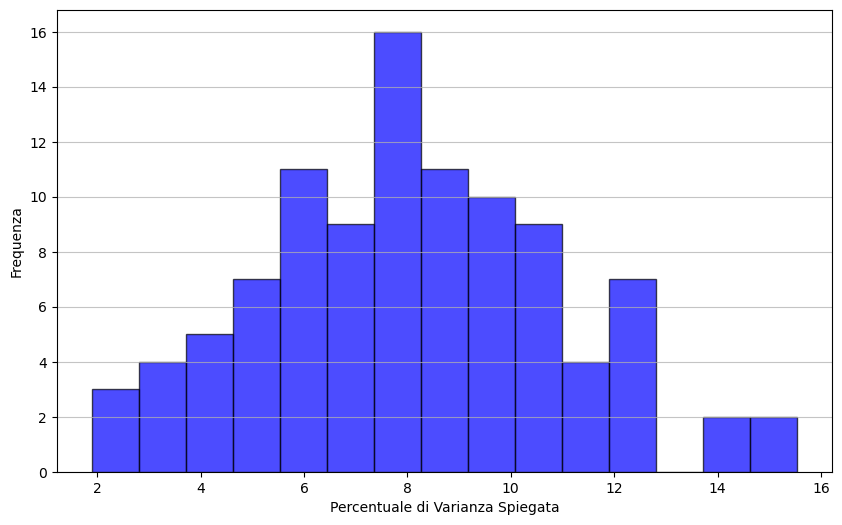

In [40]:
#GRAFICO DISTRIBUZIONE SIMULATA
plt.figure(figsize=(10, 6))
plt.hist(diff_varianza_spiegata_distribuzione['FED', 'EMU', 'Primo Periodo', 'high'], bins=15, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Percentuale di Varianza Spiegata')
plt.ylabel('Frequenza')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [41]:
# Inizializzazione di un nuovo dizionario per memorizzare le differenze osservate ΔF1
delta_F1_osservate = {}

for chiave, varianza_spiegata in varianza_spiegata_dizionario.items():
    # Estrai i componenti della chiave
    bc, stato, periodo, condizione = chiave
    
    # Chiave di controllo (no) per la stessa banca centrale, stato e periodo
    chiave_controllo = (bc, stato, periodo, 'no')
    
    # Controlla se esiste la condizione di controllo corrispondente nel dizionario
    if chiave_controllo in varianza_spiegata_dizionario:
        # Calcola la differenza ΔF1 tra la condizione corrente e la condizione di controllo (no)
        delta_F1 = varianza_spiegata - varianza_spiegata_dizionario[chiave_controllo]
        
        # Memorizza la differenza calcolata nel nuovo dizionario
        delta_F1_osservate[chiave] = delta_F1

# A questo punto, delta_F1_osservate contiene le differenze ΔF1 osservate per low, high, all rispetto a no

In [42]:
#delta_F1_osservate
stampa_valori_ordinati(delta_F1_osservate)

	MONDO & 13.46 & -6.62 & -2.12 & 0.0 & & 10.23 & 1.17 & 2.49 & 0.0 \\
	EMU & -0.93 & -1.97 & 0.61 & 0.0 & & 12.97 & -13.67 & 0.51 & 0.0 \\
	DV-exEMU & -0.92 & 6.96 & 1.0 & 0.0 & & 0.79 & -5.37 & -1.88 & 0.0 \\
	EM & 12.59 & 3.21 & 0.47 & 0.0 & & 3.19 & 8.37 & -2.08 & 0.0 \\
	EM-EMEA & 4.88 & -2.68 & -5.6 & 0.0 & & 9.86 & 2.61 & -3.75 & 0.0 \\
	EM-A\&P & -2.38 & 3.9 & -5.74 & 0.0 & & 21.9 & 2.77 & 3.28 & 0.0 \\
	EM-AM & 21.61 & 1.11 & 10.72 & 0.0 & & 10.23 & -4.17 & 5.18 & 0.0 \\
	Index & -2.92 & -13.08 & -4.78 & 0.0 & & -1.7 & -1.9 & -0.17 & 0.0 \\

	MONDO & 10.24 & 10.3 & 9.95 & 0.0 & & 5.32 & -4.31 & 0.97 & 0.0 \\
	EMU & 9.82 & 7.96 & 7.73 & 0.0 & & 3.27 & -3.01 & 1.25 & 0.0 \\
	DV-exEMU & 4.0 & -6.41 & 0.44 & 0.0 & & 0.72 & -7.54 & 0.17 & 0.0 \\
	EM & 18.06 & 17.12 & 14.94 & 0.0 & & 15.06 & 11.5 & 5.72 & 0.0 \\
	EM-EMEA & 13.84 & 10.4 & 12.55 & 0.0 & & 6.34 & 0.14 & -0.85 & 0.0 \\
	EM-A\&P & 15.5 & 8.76 & 9.24 & 0.0 & & 6.25 & 5.41 & 2.81 & 0.0 \\
	EM-AM & 15.02 & 14.31 & 10.76 & 0.

In [43]:
def calcola_p_values_bilaterale(delta_F1_osservate, diff_varianza_spiegata_distribuzione):
    p_values = {}

    for chiave, delta_F1 in delta_F1_osservate.items():
        if chiave in diff_varianza_spiegata_distribuzione:
            distribuzione_simulata = diff_varianza_spiegata_distribuzione[chiave]
            
            # Calcola quanti valori simulati sono più estremi del valore osservato (sia in positivo che in negativo)
            estremi = np.sum(np.abs(distribuzione_simulata) >= np.abs(delta_F1))
            
            # Calcola il p-value per un test a due code moltiplicando la frazione degli estremi per 2
            p_value = (estremi / len(distribuzione_simulata)) 
            
            # Assicura che il p-value non superi 1
            p_values[chiave] = p_value #min(p_value, 1.0)

    return p_values

In [44]:
# Calcola i p-values utilizzando le differenze ΔF1 osservate e la distribuzione dei valori simulati
p_values = calcola_p_values_bilaterale(delta_F1_osservate, diff_varianza_spiegata_distribuzione)


In [45]:
p_values

{('BCE', 'MONDO', 'Primo Periodo', 'low'): 0.1,
 ('BCE', 'MONDO', 'Primo Periodo', 'high'): 0.93,
 ('BCE', 'MONDO', 'Primo Periodo', 'all'): 0.79,
 ('FED', 'MONDO', 'Primo Periodo', 'low'): 0.37,
 ('FED', 'MONDO', 'Primo Periodo', 'high'): 0.32,
 ('FED', 'MONDO', 'Primo Periodo', 'all'): 0.38,
 ('BCE', 'MONDO', 'Secondo Periodo', 'low'): 0.42,
 ('BCE', 'MONDO', 'Secondo Periodo', 'high'): 0.9,
 ('BCE', 'MONDO', 'Secondo Periodo', 'all'): 0.7,
 ('FED', 'MONDO', 'Secondo Periodo', 'low'): 0.5,
 ('FED', 'MONDO', 'Secondo Periodo', 'high'): 0.67,
 ('FED', 'MONDO', 'Secondo Periodo', 'all'): 0.76,
 ('BCE', 'EMU', 'Primo Periodo', 'low'): 0.97,
 ('BCE', 'EMU', 'Primo Periodo', 'high'): 0.87,
 ('BCE', 'EMU', 'Primo Periodo', 'all'): 0.82,
 ('FED', 'EMU', 'Primo Periodo', 'low'): 0.46,
 ('FED', 'EMU', 'Primo Periodo', 'high'): 0.51,
 ('FED', 'EMU', 'Primo Periodo', 'all'): 0.35,
 ('BCE', 'EMU', 'Secondo Periodo', 'low'): 0.51,
 ('BCE', 'EMU', 'Secondo Periodo', 'high'): 0.49,
 ('BCE', 'EMU', '